In [ ]:
#%%

import os
import copy
import Blob_Detector as blob
import numpy as np
import cv2
import yaml
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

custom_labels = ['background', 'skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 
					'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

In [ ]:
#%%

input_path='output/*.npy'
files=natsorted(glob.glob(input_path))
output_path='blob_output'
if not os.path.exists(output_path):
    os.makedirs(output_path)
# predictor_path = 'C:\\Users\\festi\\Downloads\\shape_predictor_68_face_landmarks.dat'

INDEX = 136

In [ ]:
#%%

image_full = np.load(files[INDEX])
image = image_full[:,:,:3]
mask_full = image_full[:,:,3]


mask_skin = np.where(mask_full==1, 1, 0)
mask_nose = np.where(mask_full==2, 1, 0)
mask_skin = np.repeat(mask_skin[:,:,np.newaxis], 3, axis=2)
mask_nose = np.repeat(mask_nose[:,:,np.newaxis], 3, axis=2)
mask_l = [mask_skin, mask_nose]
color_l = [(255,0,0), (0,255,0)]
label_l = ['skin', 'nose']

coor_skin = []
coor_nose = []

In [ ]:
#%%

params = blob.init_params()
print('Show Params')
for attr in dir(params):
    if not attr.startswith("_"):
        print(attr, "=", getattr(params, attr))

with open("blob_detector_params.yaml", "r") as file:
    loaded_params = yaml.safe_load(file)

for attr, value in loaded_params.items():
    if hasattr(params, attr):
        setattr(params, attr, value)

Show Params
blobColor = 0
collectContours = False
filterByArea = True
filterByCircularity = False
filterByColor = True
filterByConvexity = True
filterByInertia = True
maxArea = 5000.0
maxCircularity = 3.4028234663852886e+38
maxConvexity = 3.4028234663852886e+38
maxInertiaRatio = 3.4028234663852886e+38
maxThreshold = 220.0
minArea = 25.0
minCircularity = 0.800000011920929
minConvexity = 0.949999988079071
minDistBetweenBlobs = 10.0
minInertiaRatio = 0.10000000149011612
minRepeatability = 2
minThreshold = 50.0
thresholdStep = 10.0


In [ ]:
#%%

def clone_params(source_params):
    cloned = cv2.SimpleBlobDetector_Params()
    for attr in dir(source_params):
        if not attr.startswith("_") and hasattr(source_params, attr):
            setattr(cloned, attr, getattr(source_params, attr))
    return cloned

In [ ]:
#%%

# Define the parameter sets with associated colors
param_sets = []

# Parameter Set 1
params1 = clone_params(params)
params1.maxArea = 5000
param_sets.append((params1, (255, 0, 0), 'Default'))  # Red default settings

# Parameter Set 2
# params2 = clone_params(params)
# params2.maxArea = 1000
# param_sets.append((params2, (0, 255, 0), 'maxArea=1000'))  # Green


overlay = np.copy(image)
overlay = overlay.astype(np.uint8)

In [ ]:
# %%

img = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
img[:, :, :] = image[:, :, :]
im = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
im[:, :, :] = 0 ## stores image after blur
im = cv2.GaussianBlur(img, (3, 3), 1) # original (5,5)

skin
(603.060302734375, 607.1368408203125)
(662.7315063476562, 555.4094848632812)
(595.970703125, 540.9267578125)
(645.7522583007812, 653.0101318359375)
nose


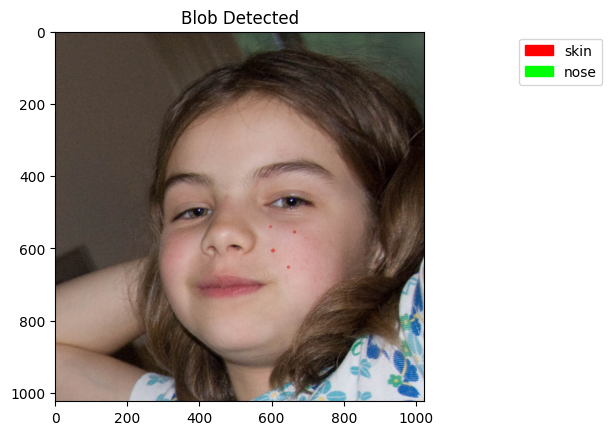

In [ ]:
# %%

legend_patches = []
detector = blob.init(params)

# Loop through each parameter set
for mask, color, label in zip(mask_l, color_l, label_l):
    # Detect keypoints
    mask = mask.astype(np.uint8)
    img_in = im*mask
    img_in = img_in.astype(np.uint8)
    keypoints = detector.detect(im*mask)

    print(label)
    for keypoint in keypoints:
        print(keypoint.pt)
    
        if(label == 'skin'):
            coor_skin.append(keypoint.pt)
        if(label == 'nose'):
            coor_nose.append(keypoint.pt)

    
    # Draw the keypoints on the overlay with the given color
    overlay = cv2.drawKeypoints(overlay, keypoints, np.array([]), color, 
                                cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    if len(overlay.shape) == 3:
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    
    legend_patches.append(mpatches.Patch(color=np.array(color) / 255.0, label=label))

# Display the image using Matplotlib
plt.imshow(overlay)
plt.title("Blob Detected")
plt.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True, bbox_to_anchor=(1.5, 1))
plt.show()

np.save(output_path + '/' + files[INDEX][-9:-4] + '_coor_skin.npy', coor_skin)
np.save(output_path + '/' + files[INDEX][-9:-4] + '_coor_nose.npy', coor_nose)